In [1]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Setup complete ✅ (12 CPUs, 7.7 GB RAM, 109.9/1006.9 GB disk)


In [2]:
!nvidia-smi

Sun Jul  7 13:24:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.03              Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:01:00.0  On |                  N/A |
| N/A   68C    P8             15W /   80W |    1153MiB /   6144MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Importar Módulos

In [3]:
import cv2
from PIL import Image
from ultralytics import YOLO, solutions
import IPython.display as dp

### Path imagen de prueba

In [4]:
img_test='test_images/001015.jpg'

### Path de los 3 pesos del entrenamiento con mejor resultado

In [5]:
weigths_path='weigths'
crosswalk_weight=f'{weigths_path}/crosswalks.pt'
lights_weight=f'{weigths_path}/lights.pt'
persons_cars_weigth=f'{weigths_path}/persons_cars.pt'

#### Funciones Auxiliares

In [6]:
import PIL as pil
def plot_image(results):
    # Visualize the results
    for i, r in enumerate(results):
        # Plot results image
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = pil.Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

        # Show results to screen (in supported environments)
        r.show()

        # Save results to disk
        r.save(filename=f"crosswalk_model{i}.jpg")
        # Save weights to disk
        print(f'probabilidad {r.probs}')

In [7]:
from ultralytics.engine.results import Results
def get_bounding_boxes(results:list[Results])->list[dict]:
    temp:list[dict]=[]

    for result in results:
         #    {'coordinates': [10, 20, 100, 120], 'name': 'Objeto 1', 'probability': 0.9},
        # Extraer los nombres de los boxes
        result=result[0]
        names:dict[int,str]=result.names
        #print(f'names \n {names}')
        boxes=result.boxes
        #print(f'boxes \n {boxes}')
        types=list(map(int,boxes.cls.tolist()))
        #print(f'cls::: \n {type(types)}-- {types}')
        coordinates=boxes.xyxy.tolist()
        #print(f'coordinates \n {type(coordinates)} -- {coordinates} ')
        probs=boxes.conf.tolist()
        #print(probs)
        d={}
        for i,item in enumerate(coordinates,0):

             temp.append({'coordinates':item,'name':names[types[i]],'probability':probs[i]})
    
    return temp

In [16]:
from IPython.display import display, Image
def draw_and_save_bounding_boxes(image_path: str,output_img_name:str, bbox_data_list:list[dict],output_path: str='/home/SafeCross/output_img'):
    """
        ## Ejemplo de uso
        #bbox_data_list = [
        #    {'coordinates': [10, 20, 100, 120], 'name': 'Objeto 1', 'probability': 0.9},
        #    {'coordinates': [150, 160, 250, 260], 'name': 'Objeto 2', 'probability': 0.8}
        #]
        #
        #draw_and_save_bounding_boxes('path/to/image.jpg', '/output_img', bbox_data_list)
        #
    """
    
    # Leer la imagen desde el path especificado
    image = cv2.imread(image_path)
    i = image_path.rfind('/')
    image_name = image_path[i + 1:-4]
    
    # Convertir la imagen a escala de grises para simplificar el proceso de dibujo
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Colores en base a los tags 
    # Definición de colores para diferentes etiquetas en RGB
    colores_etiquetas = {
    "car": (0, 0, 255),  # Rojo
    "person": (0, 255, 0),  # Verde
    "crosswalk": (255, 165, 0),  # Naranja
    "light": (255, 128, 0),  # otro
    }

    
    # Iterar sobre cada bounding box en la lista de datos
    for bbox_data in bbox_data_list:
        # Extraer las coordenadas del bounding box, el nombre y la probabilidad
        x_min, y_min, x_max, y_max = map(int, bbox_data['coordinates'])
        name = bbox_data['name']
        probability = bbox_data['probability']
        
        color=colores_etiquetas[name] if name in colores_etiquetas else (255, 128, 0)
        
        # Dibujar el bounding box en la imagen
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) #azul rgb
        
        # Calcula la posición central del rectángulo para el texto
        text_x = int((x_min + x_max) / 2)
        text_y = int(y_min)  # Ajusta esto según dónde quieras colocar verticalmente el texto

        # Define el texto que quieres añadir
        nombre = f"{name}: {probability:.2f}"

        # Configura el estilo, tamaño y color del texto
        font_scale = 0.5
        font_thickness = 2
        text_color = (255, 125, 125)  # Rojo en BGR

        # Añade el texto encima del rectángulo
        cv2.putText(image, nombre, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
    
    # Guardar la imagen con los bounding boxes en un nuevo archivo
    output_filename = f'{output_path}/{output_img_name}_{image_name}.jpg'
    success = cv2.imwrite(output_filename, image)
    if not success:
        print(f"Error al guardar la imagen: {output_filename}")
    
    # Mostrar la imagen con los bounding boxes dibujados en el cuaderno Jupyter
    display(Image(filename=output_filename))
    print(f'La imagen con los bounding boxes fue guardada y mostrada como {output_filename}')

## Cargar los modelos a YoloV8 por separado

In [9]:
crosswalk_model=YOLO(crosswalk_weight)
lights_model=YOLO(lights_weight)
persons_cars_model=YOLO(persons_cars_weigth)

## Ver resultados para el cruce de peatones


image 1/1 /home/SafeCross/test_images/001015.jpg: 512x288 3 crosswalks, 94.3ms
Speed: 75.0ms preprocess, 94.3ms inference, 2569.5ms postprocess per image at shape (1, 3, 512, 288)


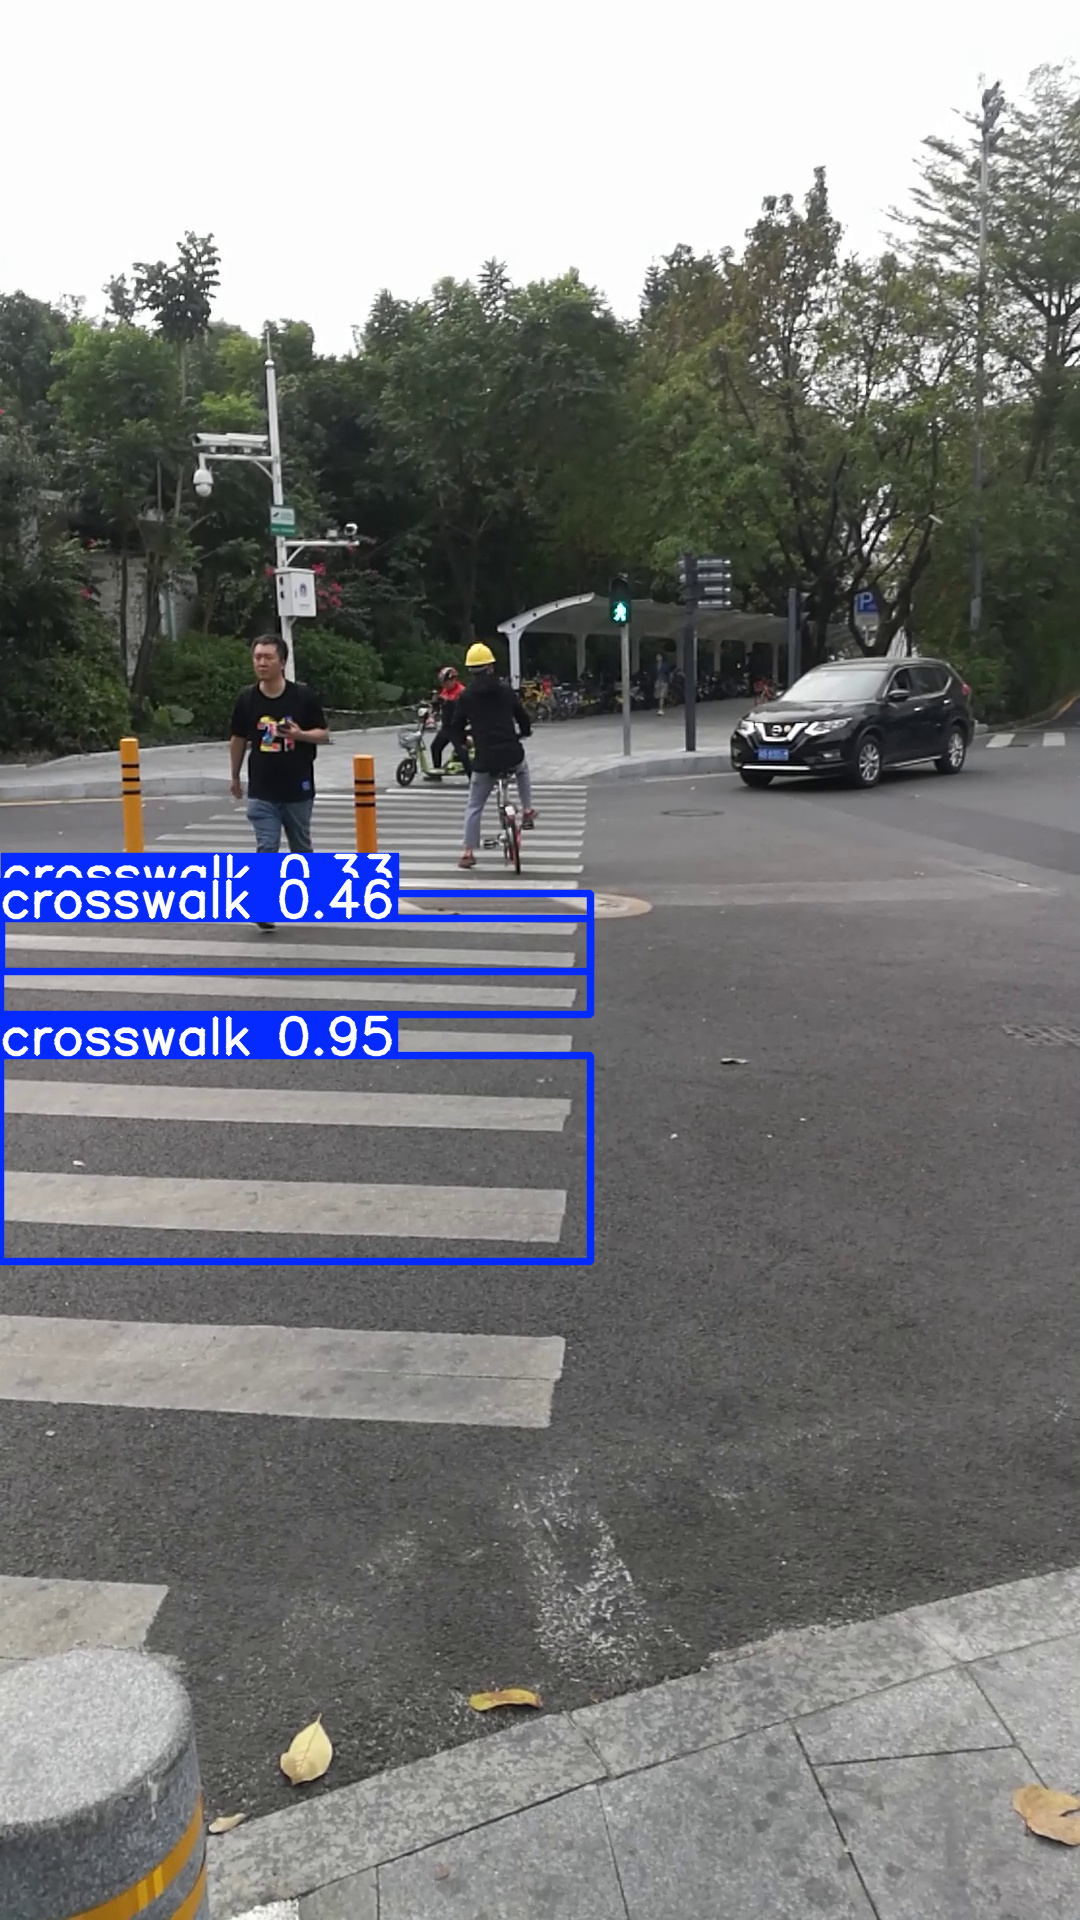

probabilidad None


In [10]:
crosswalks_results = crosswalk_model(img_test,conf=0.1)  # results list


plot_image(crosswalks_results)



image 1/1 /home/SafeCross/test_images/001015.jpg: 480x288 2 persons, 1 car, 244.8ms
Speed: 3.6ms preprocess, 244.8ms inference, 8.4ms postprocess per image at shape (1, 3, 480, 288)


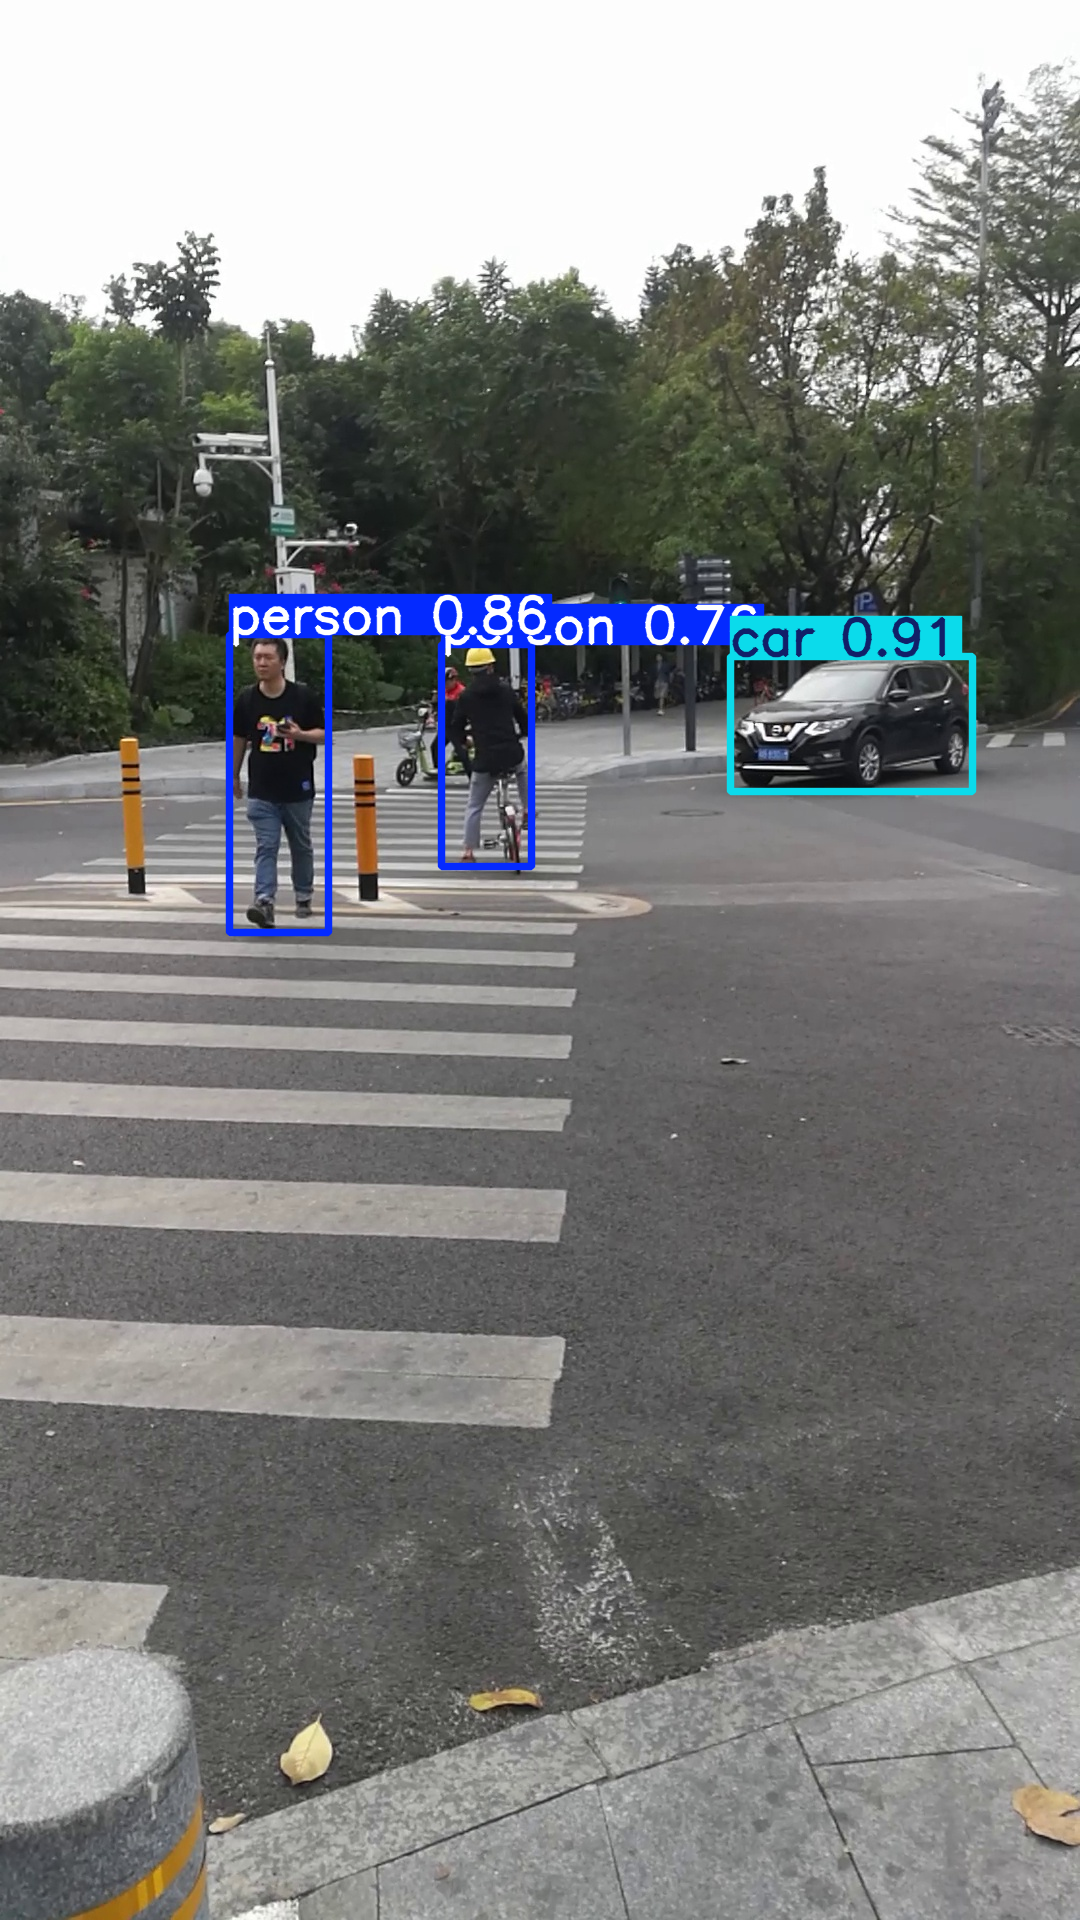

probabilidad None


In [11]:
from PIL import Image
persons_cars_results = persons_cars_model(img_test,)  # results list

plot_image(persons_cars_results)



image 1/1 /home/SafeCross/test_images/001015.jpg: 640x384 1 verde, 351.5ms
Speed: 5.0ms preprocess, 351.5ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 384)


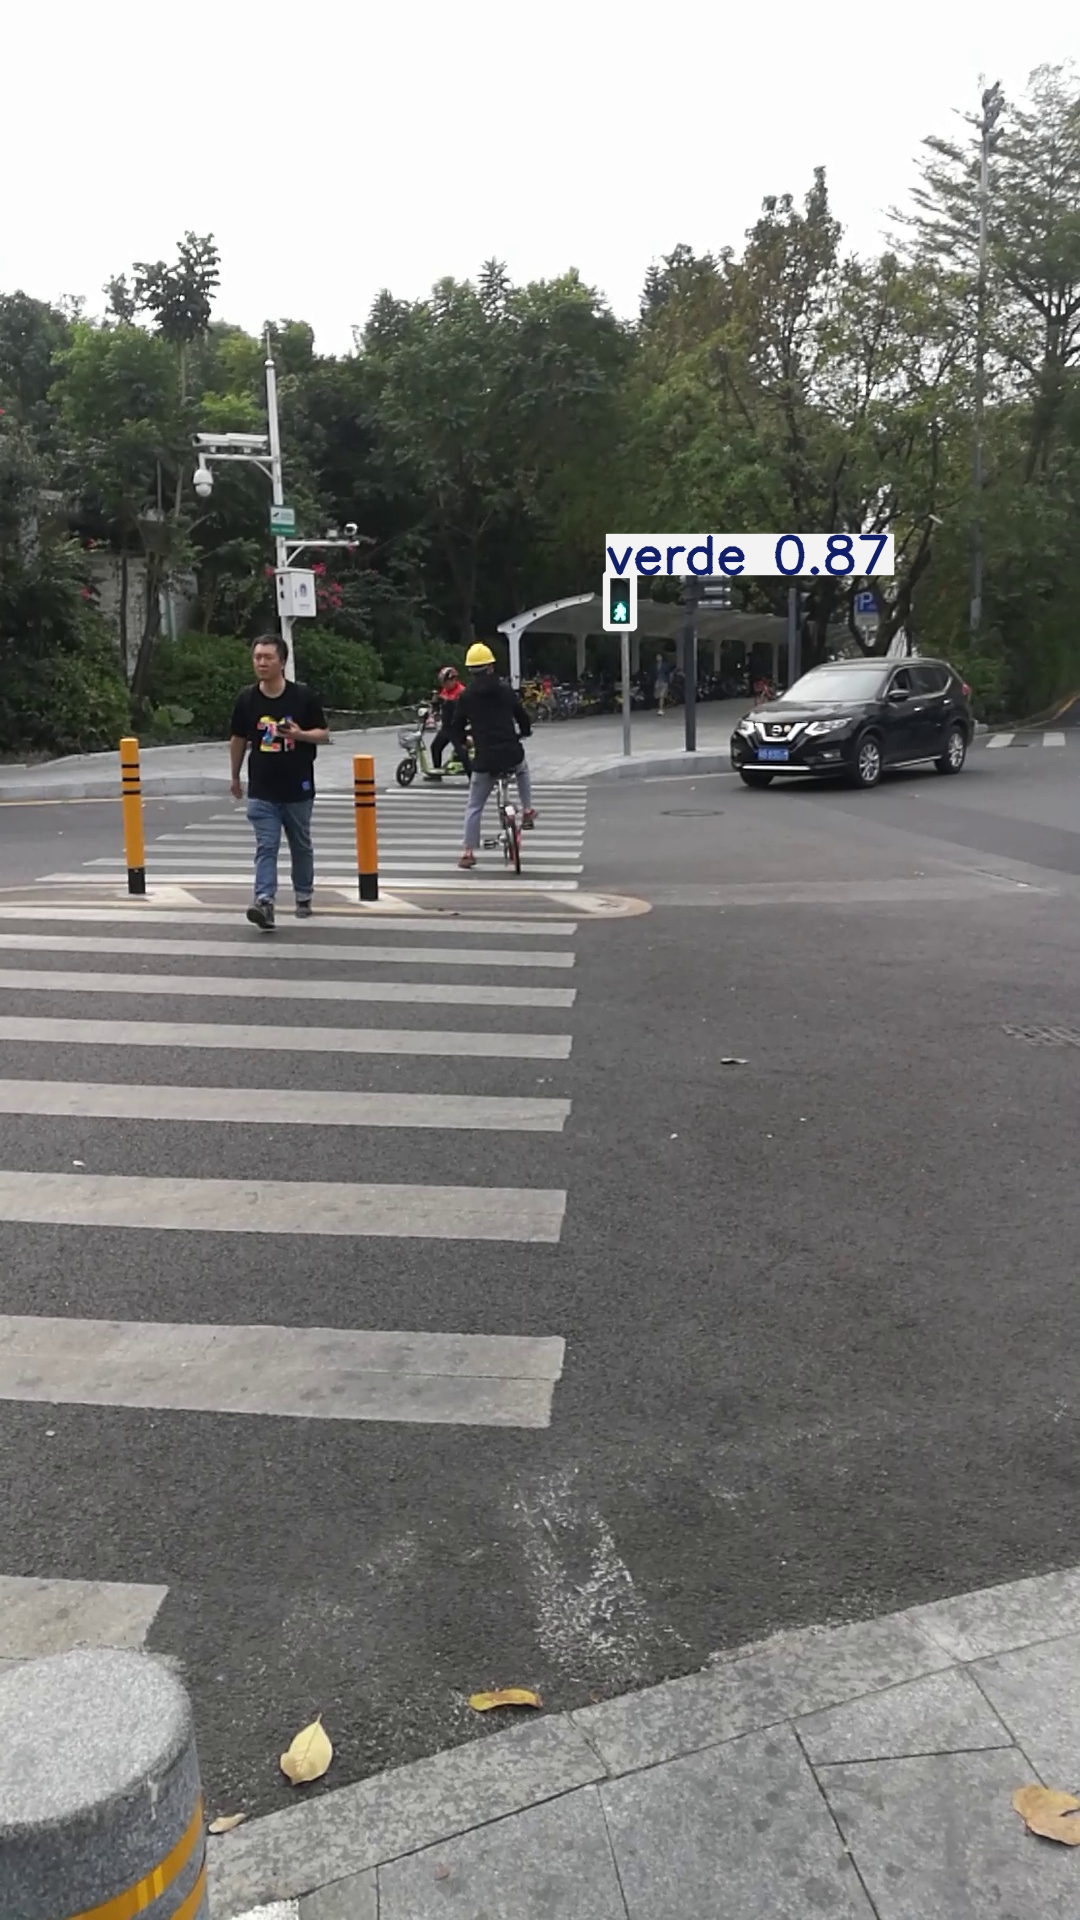

probabilidad None


In [12]:
lights_results=lights_model(img_test,)

plot_image(lights_results)

In [13]:
boxes=get_bounding_boxes([crosswalks_results,persons_cars_results,lights_results])


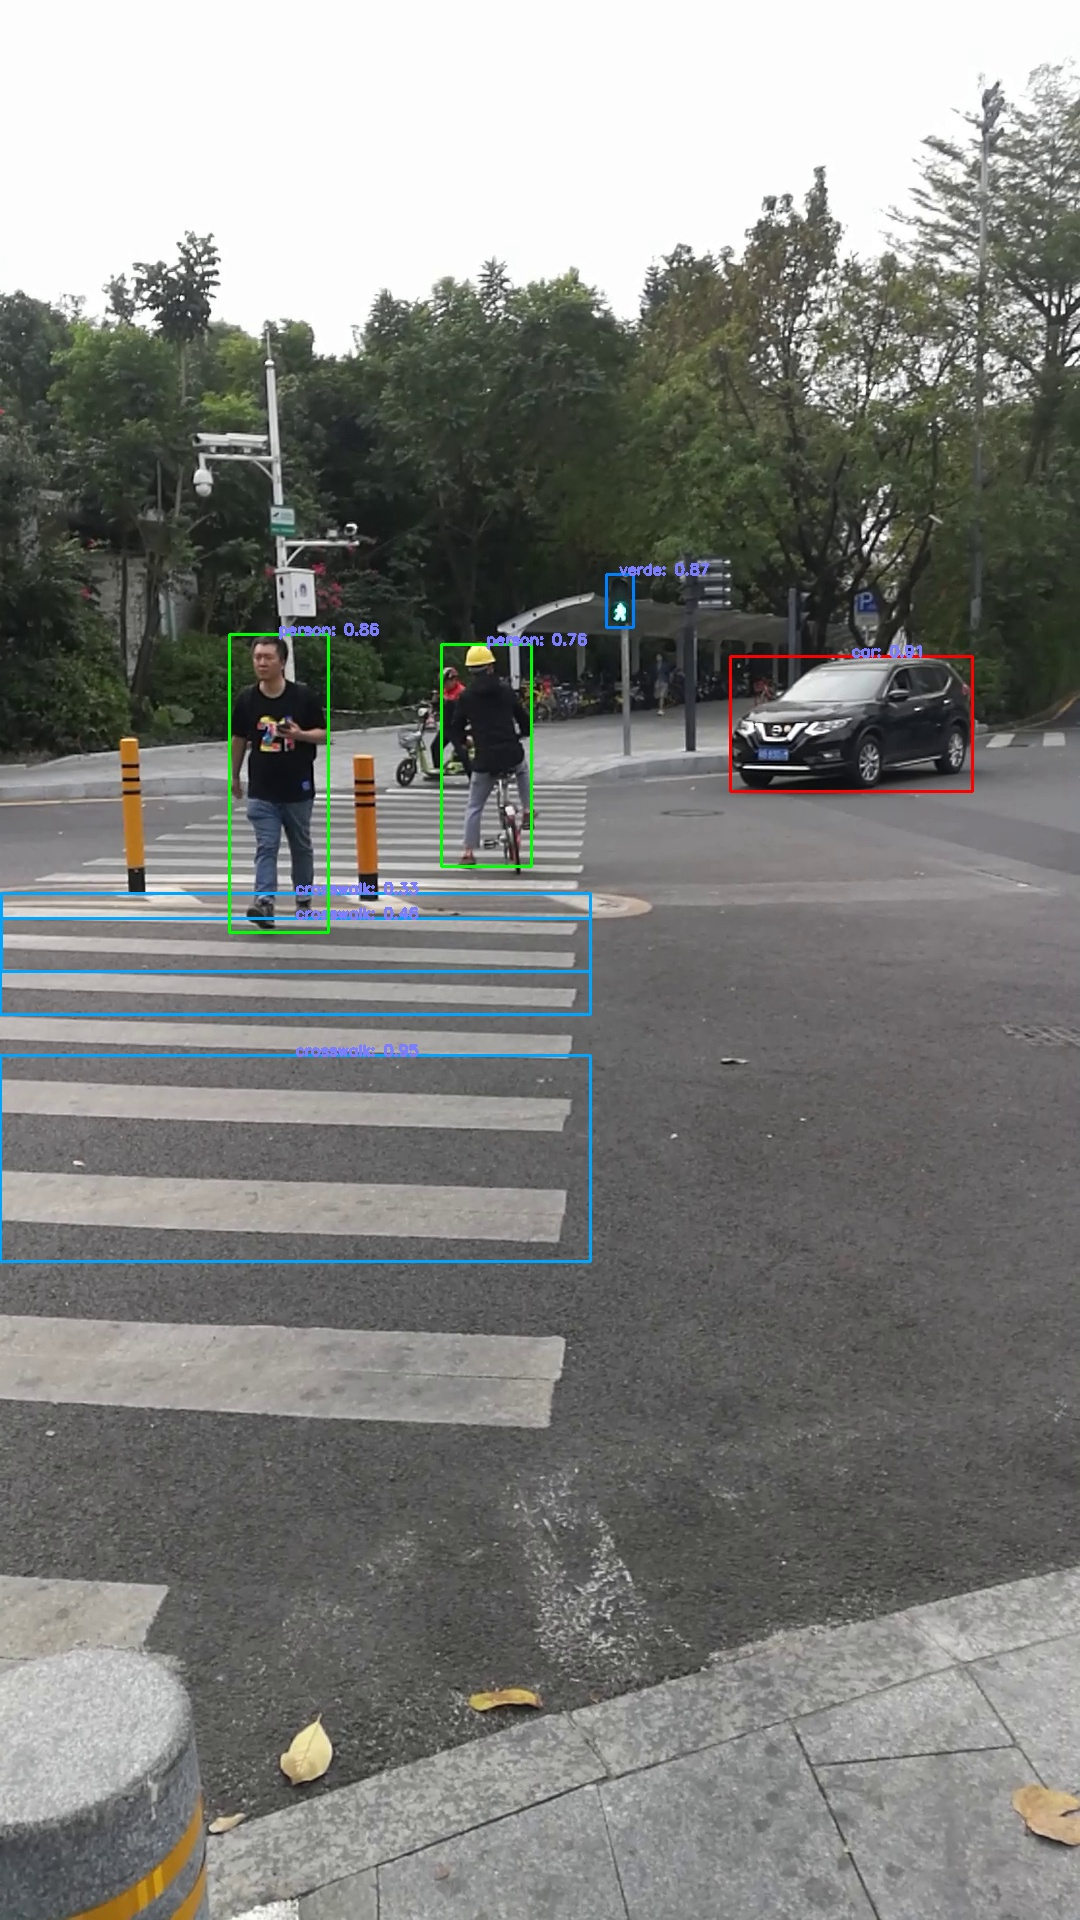

La imagen con los bounding boxes fue guardada y mostrada como /home/SafeCross/output_img/Final_001015.jpg


In [17]:
draw_and_save_bounding_boxes(img_test,'Final', boxes)